In [1]:
from IPython.display import Image as ipimag

# ..........................Report on Traffic Sign Recognition Project.............................

## 1. DATA Exploration.

The data for the project has 32x32x3 rgb cropped images of various german traffic signs. There are 39,209 samples for training and 12,630 samples for 43 unique labelled classes.
Figure shows the sorted train data characteristic. The first column is the mean image of the corresponding label over entire train set, followed by some example samples of each class, next up is the class label and classname, finally, we have the class distribution histogram and sample counts for each class.

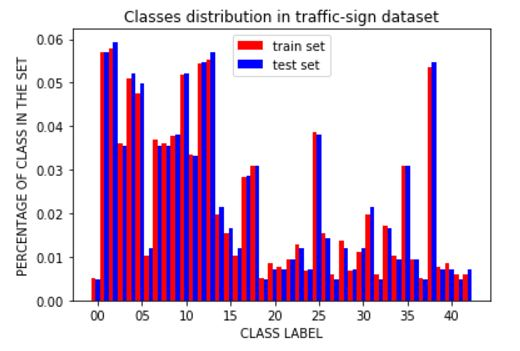

In [6]:
ipimag(filename= 'modelsol/dist.jpg')

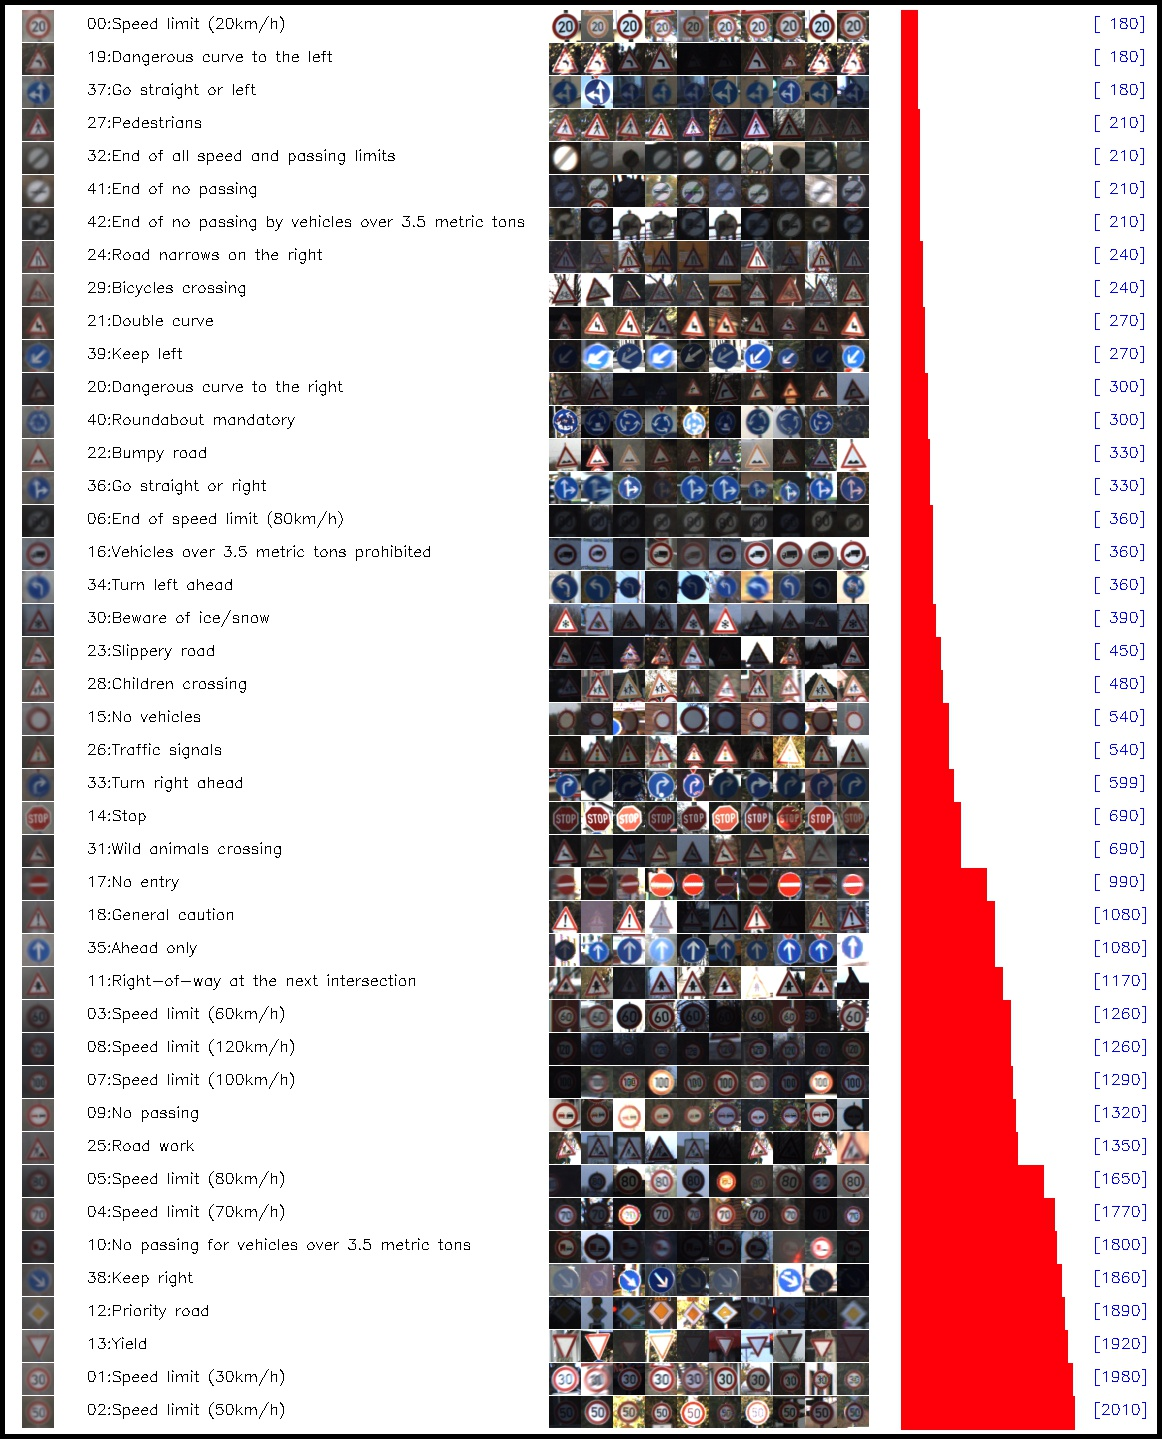

In [3]:
ipimag(filename = 'modelsol/train_data_summary.jpg')

We made the following observations:
1. The class distribution is not balenced, with the smallest class having about 200 samples, and the largest with nearly 2000 samples.
2. Within each class, samples exhibit variations. Brightness and contrast variations seems to be the most prominent along with some blur. There are also rotation, scale and other geometric transform.


# 2. Data Summary: what to do next?

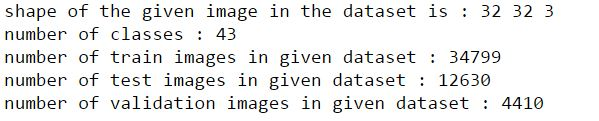

In [4]:
ipimag(filename='traffic_sign_data/stat.jpg')

The number of training examples are limited, so we need to augment the train data. An idea from [Alex Staravoitau's](http://navoshta.com/traffic-signs-classification/) methods of data augmentation has been used and it is called image fliping. It helps to nearly double the training set.

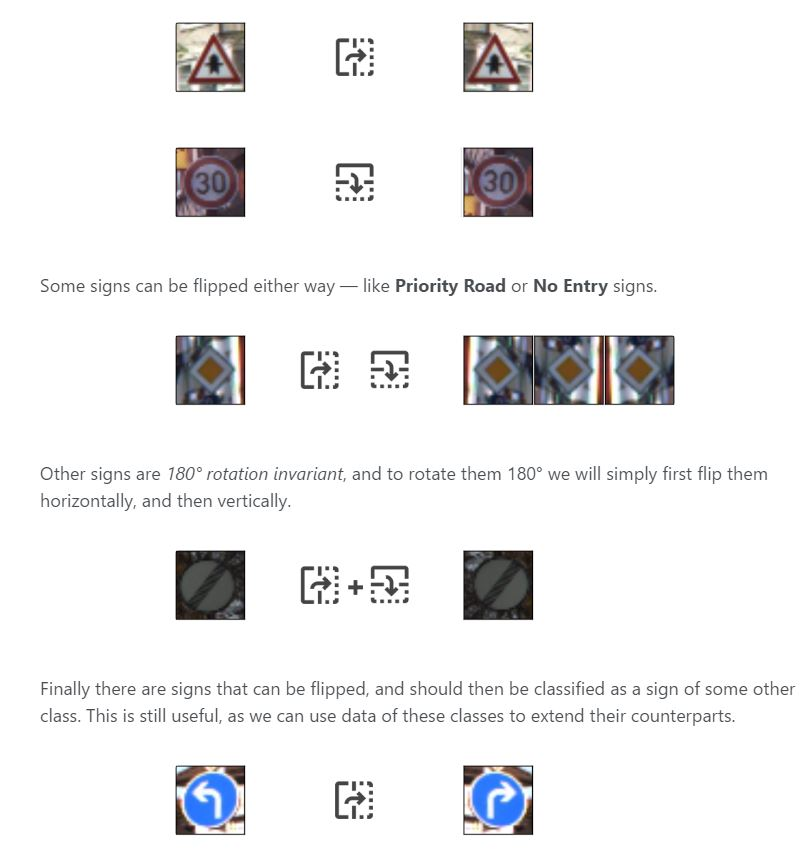

In [6]:
ipimag(filename='traffic_sign_data/flip_nav.jpg')

soure [Alex Staravoitau's](http://navoshta.com/traffic-signs-classification/) blog

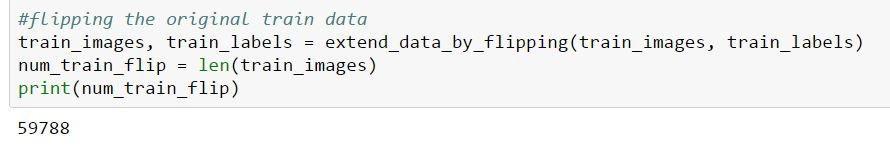

In [5]:
ipimag(filename='traffic_sign_data/flip.jpg')

Now this becomes nearly 1000 images per class, which is quite not sufficient to train a network for predicting the test images. So, a method to augment the data is required. The method used to augment the data is developed following many blogs and some research papers, the general idea for arguments is drawn from keras augmentation function. It involves a sequential random transformations performed. These transformations include rotation, scale, shear, translation, distortion, brightness, contrast.


The data augmentation is done during training time to create over 3000 samples per label. Prior data augmentation consumes lot of memory, search and split. The augmented data is randomly sampled before training. Below figure shows the augmented data.

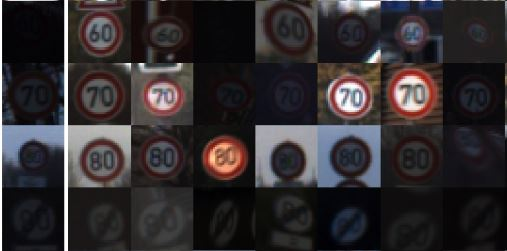

In [10]:
ipimag(filename='traffic_sign_data/aug_sample.jpg')

# 3. System design and test.
* The design is divided into three parts - 
1. **FILTER**
  * The filter stage does-preprocessing on the data while training.
  * It is made by sequentially performing batch normalization, 3x3 convolution, prelu, 1x1 convolution, prelu.
  * Idea of spatial transformer for pre-processing  on the go is learnt from [evaluation of CNN by Dmytro Mishkin et al.](https://arxiv.org/pdf/1606.02228.pdf) 
  * A 3x3 convolution is used in the first step with strides of one in all dimensions to learn structure of the given image         along the three color channels, then a parametric relu followed by a 1x1 convolution and a parametric relu to decrease the       size of the params given as a input to next stage. 
2. **Feature-extractor**
  * This stage is responsible for gaining information from images by learning features from it.
  * There are four primary blocks in this stage, the last three blocks are further divided to repetetive sub-blocks.
    * Each sub block comprises a closed loop BN layer, convolution, relu, dropout.
  * From the results of training data the number of repetitions are multiples of 3. So, the three sub blocks are designed as         follows 6-repetitions, 3-repitiotions, 3-repetitions.
3. **Classifier**
  * This last stage is made of a 1x1 covolution and  average global pooling.
  
This model resulted in a test accuracy of 99.34%

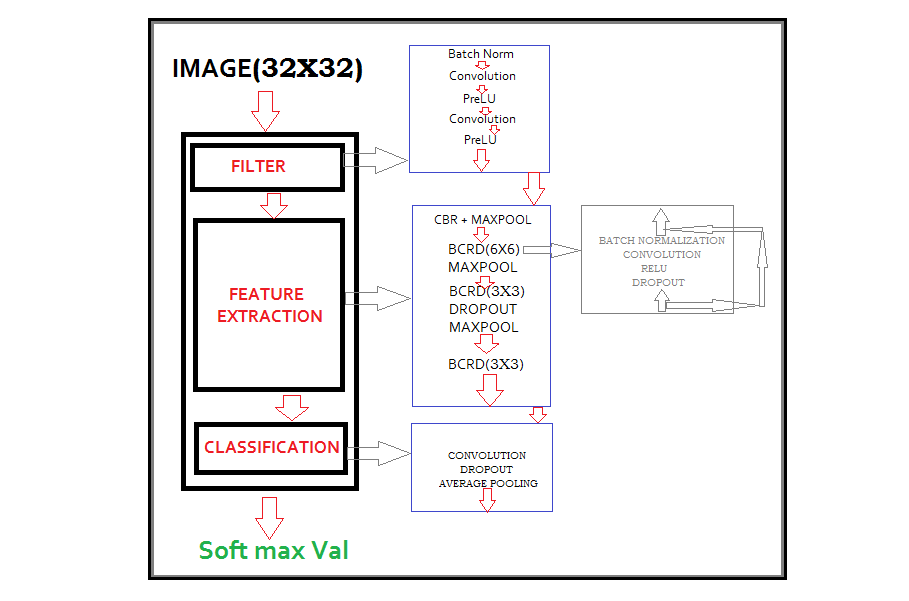

In [4]:
ipimag(filename= 'modelsol/arch.png') 

### REQUIREMENT
(1) Establish a target accuracy we want to achive. From searching Google, we know that:
    -* human performance: 98.84%
    -* industrial performance: 99.82%
    -* works by others: 99.10% to 99.67%
    Hence we think that a reasonable well trained system should be about 99.5% accuracy.

(2) Train a simple conv net to establish baseline results. Our experiments shows that
    -* simple LeNet + dropout + no augmentation: ~93%
    -* simple LeNet + dropout + augmentation: ~95%
    -* simple LeNet + dropout + augmentation + preprocessing (whitening): ~97%
    
(Note: simple LeNet = 108_5x5conv_relu-maxpool, 108_5x5conv_relu-maxpool, 100_dense_relu, 100_dense_relu, 43_dense)

From these results, we think that data agumentation and preprocessing during training could be the key to get higher results. As for newtork structure, LeNet performance seems to be saturated. I have learnt about Vgg, AlexNet, GoogleNet and Denset and decide to use Densenet as my final solution, that can run on my pc.

Based on the observations above, we try the following:

(1)  Select a network and tune it.

I choose "Densenet" becuase, it connects the lower layers to the top by concatenation. It is understood that the orginal "Densenet" is very sensitive to dropout (maybe because the dropout can propagate and get magnified within the block?).

(2)  Once we fix the network, choose pre-processing. Try whitening, LRN but find that they are quite slow and doesn't really imporve the results once we have large data argumentation. CLAHE(contrast limited adaptive histogram equilization) has been tried as a pre-processing step. 

(3) Lastly we try different augmentations. it is found that too much agumentation is no good. we need to limit to the correct rotation, scale, translate, perspective distrortion, brighness, contrast, satuation, etc. We note that final results is sensitive to argumentation. 

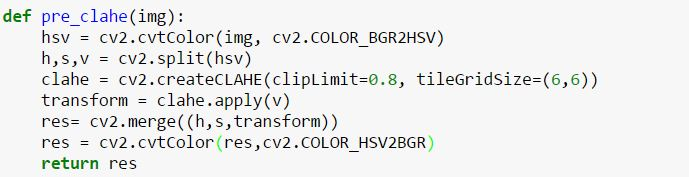

In [3]:
ipimag(filename='modelsol/clahe.jpg')

For clahe the image is first converted to hsv and split into three channels H,S,V. CLAHE is performed on V channel and the three channels are stitched back together and converted to rgb.  Hence we decide to got for something simpler, i.e. just include the preprocessing inside the network. The cliplimit and tile grid size are hyperparameters.

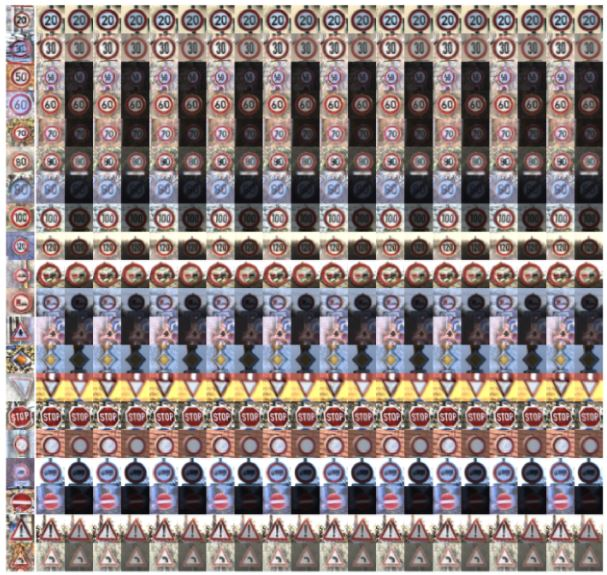

In [5]:
ipimag(filename='modelsol/climg.jpg')

It is quite evident from the image above, that CLAHE can improvise contrast of the image using local grids. The first column is the mean image of the entire dataset and the alternating columns show the difference between original and transformed images. The accuracy increased over 0.2 percent using clahe.

###### Solution
The basic idea is to create augmented train data by generating new data during the training epoch. We think that if the train data is always changing, the network will be less prone to overfitting. But we have to make sure that the data change is not too big which will otherwise cause "jumps" in the training loss.
 
Hence, we divide the training epoches into R runs. For each run, we generate new data by the formula:
    "train_data_of_current_run = 20% of original_data + 80% of new_augmented_data" 

Then, in each run, we have to decide E number of epoch to execute. From our experiments, it turns out that R=40 and E=40 work well. Total number of training epoches is about 40x40 = 1600. 

To prevent imbalance class problem, we use equal number of samples per class by random sampling during augmentation as mentioned above. We use 3000 samples per class. 

For optimizer, we use stochastic gradient descent (sgd) with momentum=0.9. The learning rate is stepped from 0.1, 0.01, 0.001, 0.0001 at rounds 0, 3, 6, 8 respectively. Batch size should be preferably greater than the number of class (43) and we choose to use batch size = 128.

Finally we achieve 99.38% on the test set. We note that due to different random seed, the results is not exactly the same when we run our code.

### Experimental reuslts
note : [1,2,1] => [1 BCRD--> 2BCRD--> 1 BCRD-->] the network itself. BCRD is to be understood from above figure

#### 1. Using [1,1,2] resulted in 98.53% test accuracy
#### 2. Using [2,1,2] resulted in 98.6% test accuracy
#### 3. Using [4,2,1] resulted in 99.02% test accuracy
#### 4. Using [4,4,4] resulted in 98.89% test accuracy
#### 5. Using [6,3,1] resulted in 98.82% test accuracy
#### 6. Using [6,3,3] resulted in 99.38% test accuracy
    The batch size also has been increased to 128 from 64 as it proved to increase 0.97% increase in accuracy.

# WHY?
1. Why densenet ?
  * Through the levels in the heirarchy of deep nets, neurons at different layers get activated by parametrs like color, shapes,     objects, structures etc. But to classify a image with atmost accuracy, one should consider all of its charactristic features
    As we go down the heirarchy in a un-concatenated network we miss the intensity that lower layers create on final output.
    So, in order to utilize each and every detail from the image activations should be preserved. The architecture of dense net 
    is similar to resnet but concatenates all the layers on a whole at each layer. #reference [densenets](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)
2. How many levels ?
  * 3 levels have been designed in the model used for training. first level has 6 layers, second has 3 and the last one has 3       layers. Every layer is made of a simple BCRD(batchnorm+convolution+regularization+dropout) network. Densenet works               sensitively with dropout, so only 0.1 dropout has been used. The levels aare designed to have layers that are multiples of       three because, the input is 3 dimensional and by using layers with multiples of three the accuracy has increased notably         during experimentation.
3. How are the hyperparameters choosen ?
  * According to the rule of thumb the batch size should be definitely greater than number of classes, so batch size is fixed to     128. [source](https://www.quora.com/Should-I-use-powers-of-2-when-choosing-the-size-of-a-batch-size-when-training-my-Neural-Network)
  * 6000 is the maximum number of images per class with augmentation my ram is capable of, and it is observed that over             augmentation leads to over-fitting.
  * learning rate is decreased as the number of iterations increase, and with quite a good number of experiments. [[1]](https://www.quora.com/How-is-the-step-size-for-Stochastic-Gradient-Descent-SGD-usually-chosen-for-Convolutional-Neural-Networks-CNNS)

# Test result

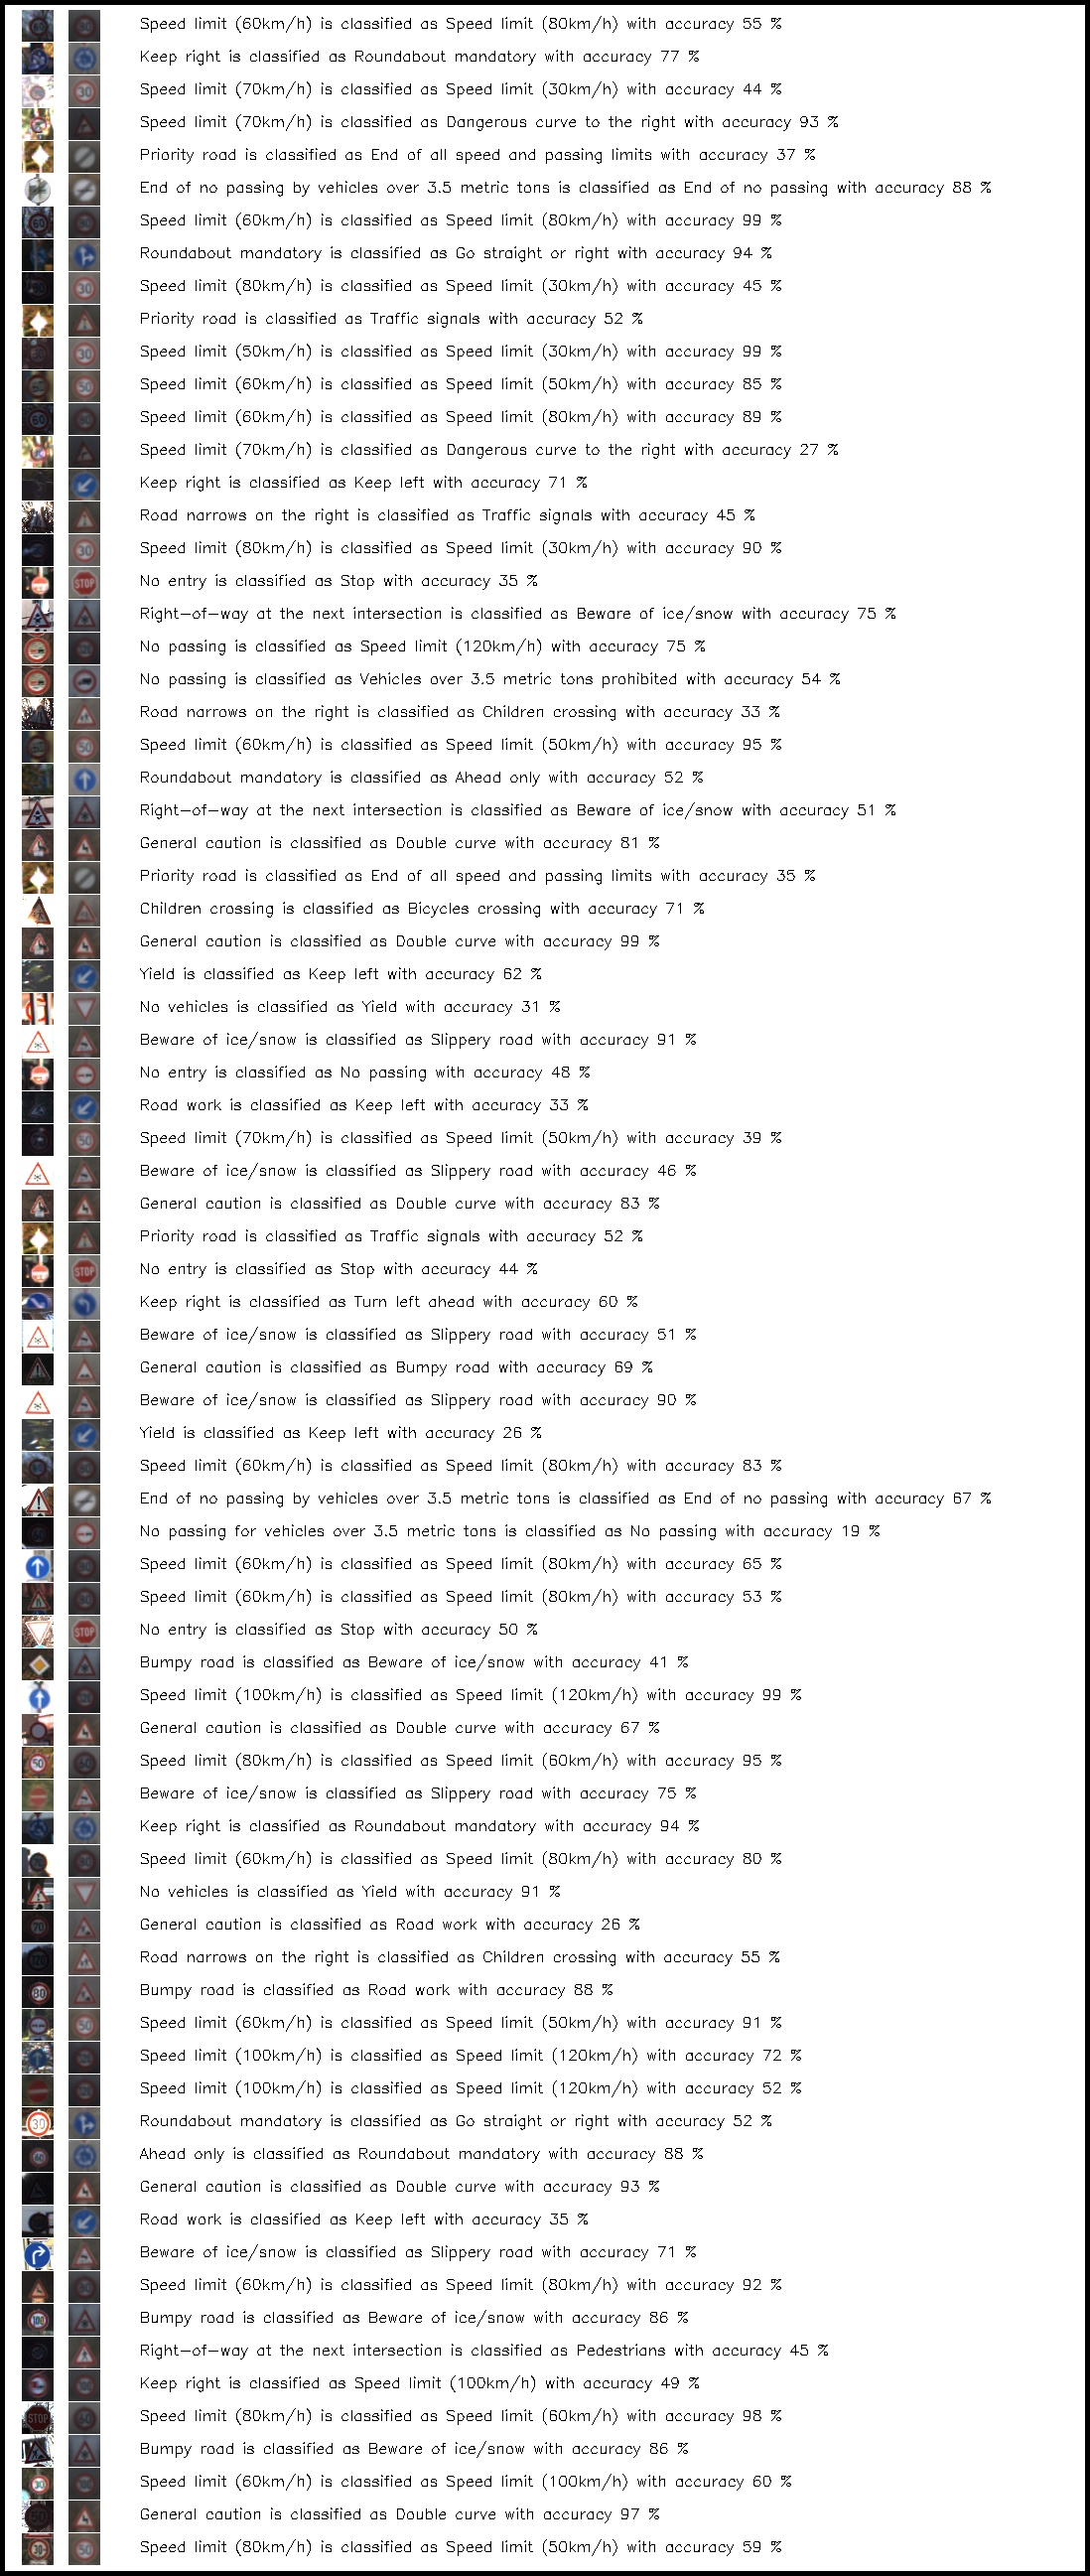

In [4]:
ipimag(filename='modelsol/test_data_summary.jpg')

** A total of 77 images are misclassified in the test set. If taken a clear look the images are mis classified because of wrong labelling in the dataset. **

So testing the model on new images can be of greater accuracy than on the test set that is provided.


# 4. Testing the model on images.
Two sets containing 5 images each are downloaded from internet. The first set contained images that are clearly visible and easy to judge thier labels, so the model was able to perform accuratley on them, by correctly classifying 5 out of 5.

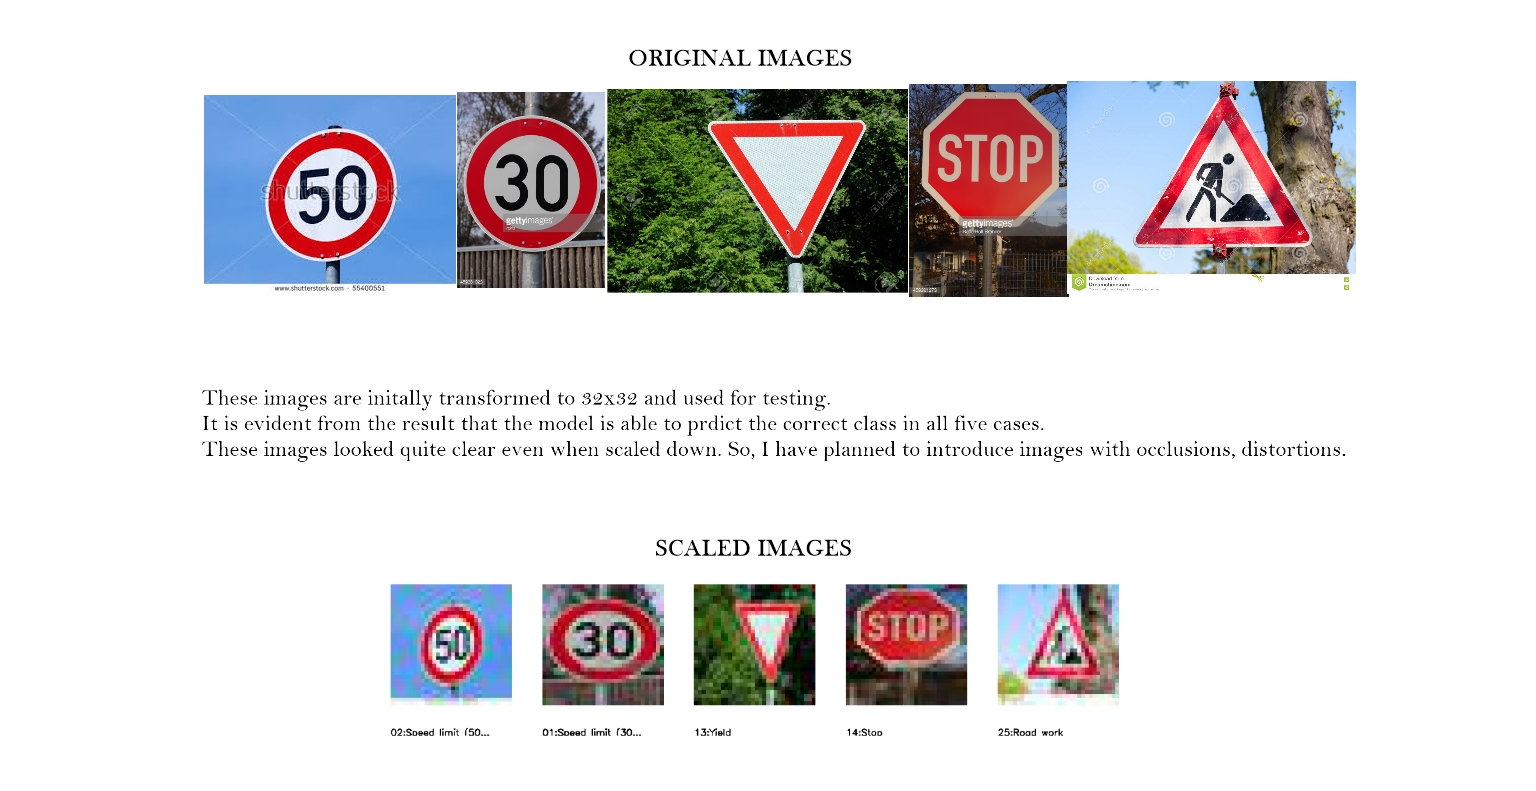

In [5]:
ipimag(filename= 'traffic_sign_data/test_data/TEST.jpg') 

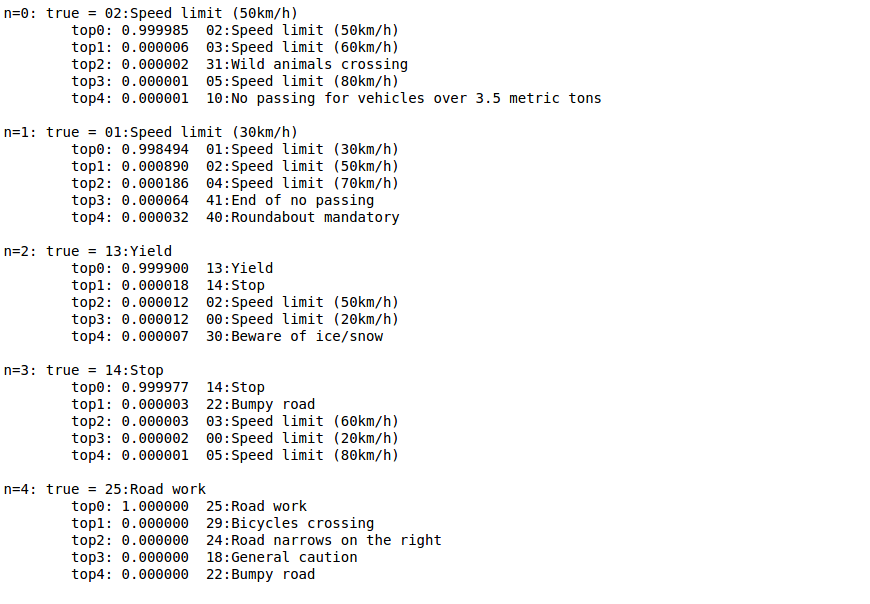

In [6]:
ipimag(filename='modelsol/result.png')

##### ** The new test images wer quite clear and short in number, but only to test the capability of the network. The network outperformed on new images with 100% accuracy, but this should not be called as over fitting as the images had no occlusion or any distubance**

The second set contained images with occlusions and some disturbances

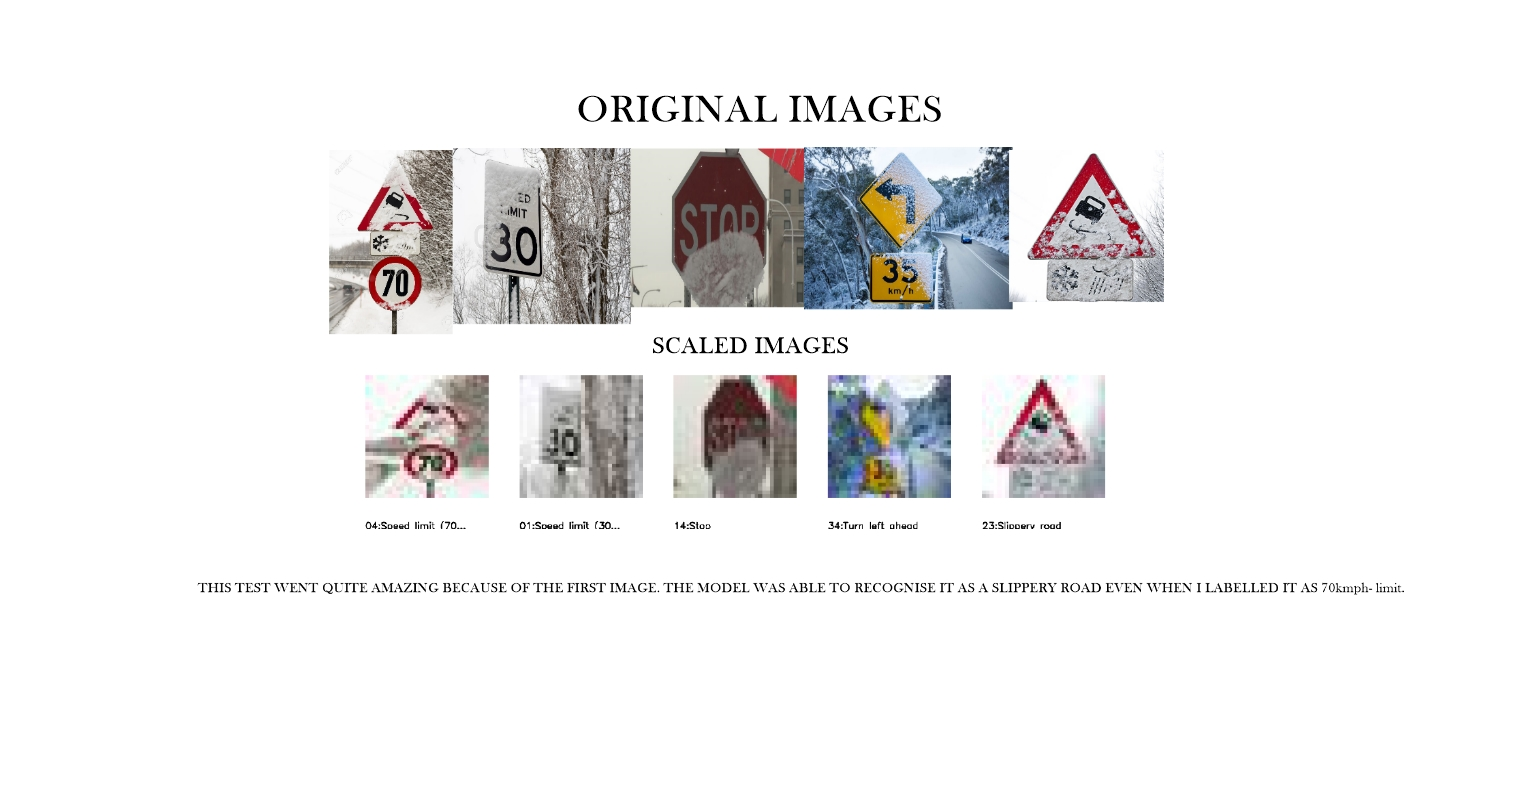

In [7]:
ipimag(filename= 'traffic_sign_data/test_data/DOWN/TEST.jpg') 

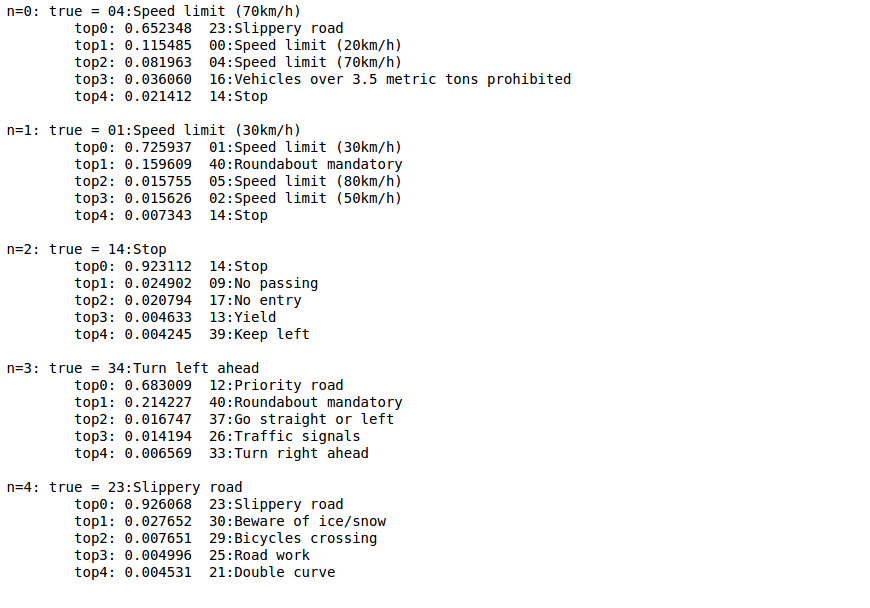

In [8]:
ipimag(filename='modelsol/result1.png')

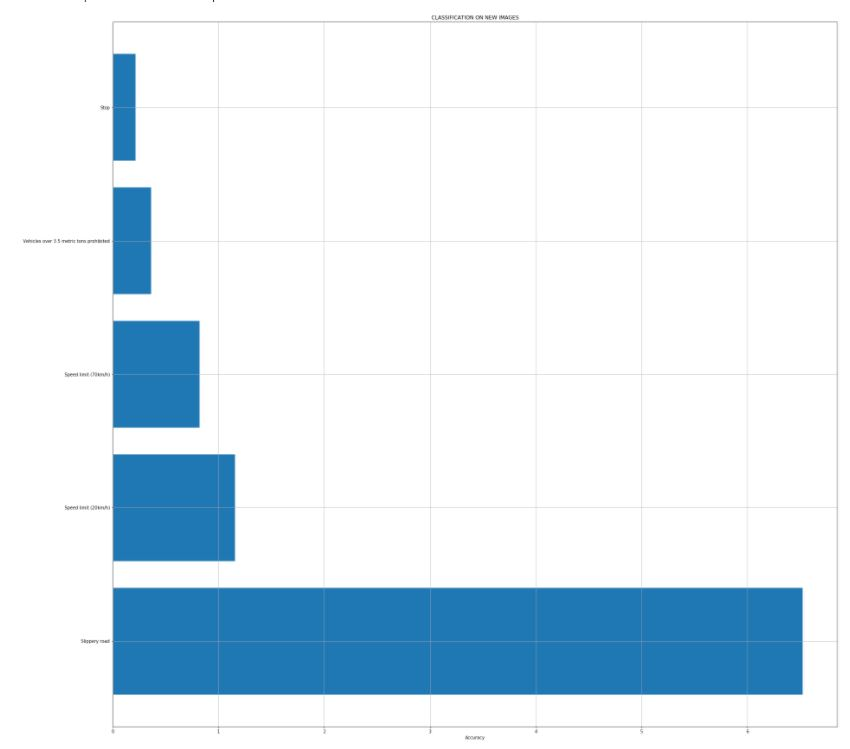

In [8]:
ipimag(filename='modelsol/slip.jpg')

It is clear from the first image in the second set that it has two signs in it namely 70kmph, slippery road. It was labelled as 70kmph as that was what i was able to judge bby viewing the image, but the network was able to classify it as a slippery road which is astounishing. All the labelled classes lie in top five classes and for the examples considered they were 100% accurate on prediction.

##### ** The new images were occluded to some part but the network was able to predict them correctly even if mislabelled. The performance of the model on new test images is good compared to the original test data that as some of the images in the original data set are completely invisible that is the contrast and illumination are not evenly distributed in the images**

### Among the wrongly classified images in the gioven test data set 60kmph sign was less precisely classified . so a test has been conducted to check the models performance on classifying 60kmph traffic sign.

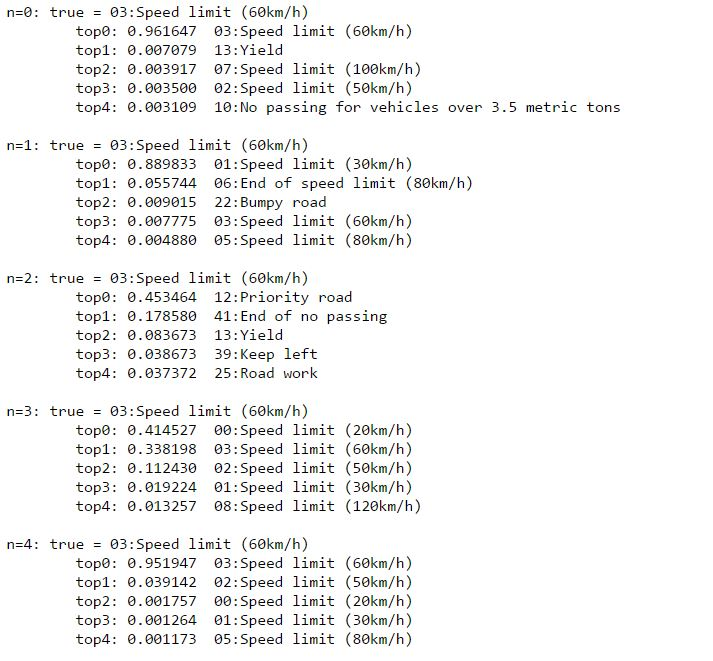

In [2]:
ipimag(filename='modelsol/60prob.jpg')

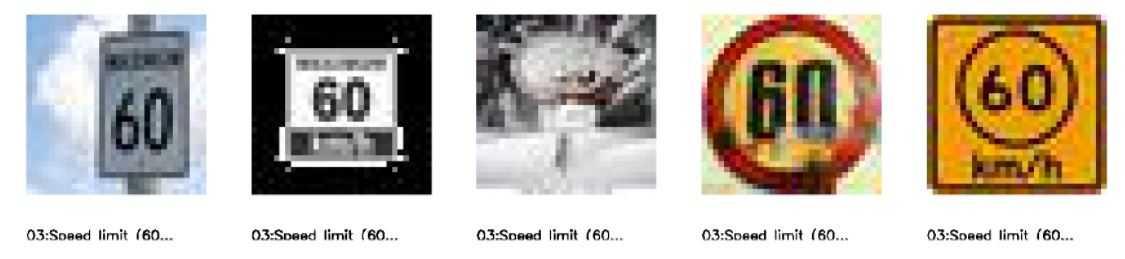

In [3]:
ipimag(filename='modelsol/60prob1.jpg')

**The model has very low precision on 60kmph sign. It could only attain 40% accuracy on that class even if the images were not highly disturbed or occluded.**

# ------------------------------------------[SUMMARY]------------------------------------------------
### The model was well trained for all the classes with good precision but it looses only over 60kmph sign class. The accuracy of the model on the given test data set is 99.38%. Data augmentation with transformations over illumination of the image played important role in increasing the accuracy of the model. The model can be tuned to get higher accuracy even on misleading judgements by training the model with more data that is labelled correctly.

#### Acknowledgements:

Before writing this Deep net everything was new to me, I was a novice in all topics, but by doing this project I had a chance to explore lots of interseting and encouraging methods for deep learning. I also had a chance to explore lot of new problems that can be solved very accurately by using deep learning. I thank Udacity and my fellow Students for helping me in learning a lot. Now I can write my own Deep neural net and not only train it but also to find spots which need to be lokked into for increasing the accuracy. Data augmentation and Dense net are two methods that impressed me the most.
I felt that Dense Net is a closed loop control unit in DEEP NEURAL NETWORK.